In [41]:
import model
import utils

import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import trange, tqdm


test = np.array([seq for seq in utils.n6_test()])
train = np.array([seq for seq in utils.n6_train()])


def gradient(X, Y):
    return X - Y


BATCH_SIZE = 32
EPOCHS = 200


net = model.RIM(
    1,
    32,
    (5, 3, 3),
    2,
    16,
    gradient,
).to("mps")
full_seq = np.zeros((400, 16, 36, 36, 1))

full_seq[:, 0] = train[:, 0]
full_seq[:, 1] = train[:, 1]
full_seq[:, 2] = train[:, 2]
full_seq[:, 3] = test[:, 0]
full_seq[:, 4] = train[:, 3]
full_seq[:, 5] = train[:, 4]
full_seq[:, 6] = train[:, 5]
full_seq[:, 7] = train[:, 6]
full_seq[:, 8] = train[:, 7]
full_seq[:, 9] = train[:, 8]
full_seq[:, 10] = train[:, 9]
full_seq[:, 11] = train[:, 10]
full_seq[:, 12] = train[:, 11]
full_seq[:, 13] = train[:, 12]
full_seq[:, 14] = train[:, 13]
full_seq[:, 15] = test[:, 1]

device = "mps"

full_seq = torch.tensor(full_seq)

train = DataLoader(full_seq, shuffle=True, batch_size=BATCH_SIZE)

In [48]:
rim = model.RIM(
    1,
    32,
    (5, 3, 3),
    1,
    15,
    gradient,
).to(device)

criterion = nn.MSELoss()
learning_rate = 0.0002
optimizer = torch.optim.Adam(rim.parameters(), lr=learning_rate)

losses = []
test_losses = []

train_images = np.zeros((EPOCHS, 36, 36, 1))
for epoch in range(EPOCHS):
    train_loss = 0.0
    train_loop = tqdm(
        enumerate(train),
        leave=False,
        desc=f"Training {epoch + 1}/{EPOCHS}",
        total=400 // BATCH_SIZE,
        unit="batch",
        postfix=f"Test Loss: {test_loss:.2f}" if epoch != 0 else None,
    )
    test_loss = 0.0
    for i, seq in train_loop:
        # print(f"INPUT: {seq.shape}")
        seq = seq.to(torch.float32).to(device).reshape((-1, 16, 1, 36, 36))
        X = Variable(seq[:, -1])
        y = Variable(seq[:, 0])

        optimizer.zero_grad()

        outputs = rim(X, y)
        # print(f"OUTPUT: {outputs.shape}")
        outputs = outputs.reshape((-1, 16, 1, 36, 36))

        loss = 0.0

        for t in range(16):
            # target = seq[:, 15 - t]
            target = seq[:, t]
            #     if i == 200 and t == 12:
            #         train_images[epoch] = (
            #             outputs[t].cpu().detach().reshape(36, 36, 1).numpy()
            #         )

            if t == 0:
                continue
            elif t == 3 or t == 15:
                test_loss += criterion(outputs[:, t], target) / 2
            loss += criterion(outputs[:, t], target) / 16

        loss.to(device)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        losses.append(train_loss.cpu().detach() / 14)
        test_losses.append(test_loss.cpu().detach())

AttributeError: 'float' object has no attribute 'cpu'

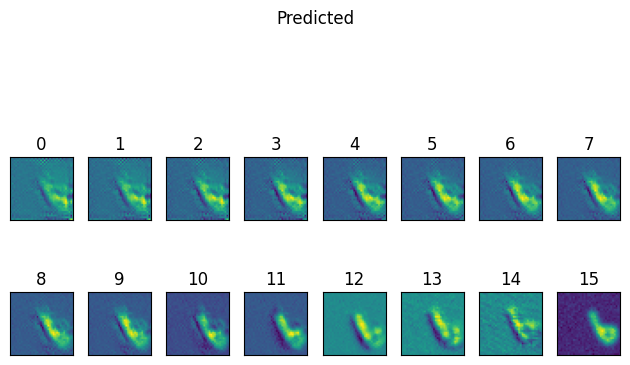

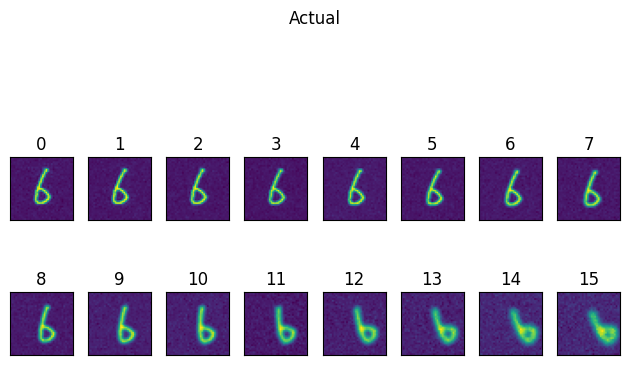

In [43]:
idx = np.random.randint(0, 400)
seq = full_seq[idx].to(torch.float32).to(device).reshape(16, 1, 1, 36, 36)
X = seq[0]
y = seq[-1]
rim.eval()
outputs = rim(X, y).cpu().detach().reshape(16, 36, 36, 1)
seq = seq.cpu().reshape(16, 36, 36, 1)


fig, axs = plt.subplots(2, 8)
fig.suptitle("Predicted")
fig.set_tight_layout(True)

for i, (ax, y_hat_i) in enumerate(zip(axs.flatten(), reversed(outputs))):
    ax.title.set_text(f"{i}")
    ax.imshow(y_hat_i.cpu().detach())
    ax.set_xticks([])
    ax.set_yticks([])

fig, axs = plt.subplots(2, 8)
fig.suptitle("Actual")
fig.set_tight_layout(True)

for i, (ax, y_i) in enumerate(zip(axs.flatten(), seq)):
    ax.imshow(y_i.cpu().detach())
    ax.title.set_text(f"{i}")
    ax.set_xticks([])
    ax.set_yticks([])

In [13]:
torch.save(rim.state_dict(), f"./rim-{epoch}-epochs.pt")

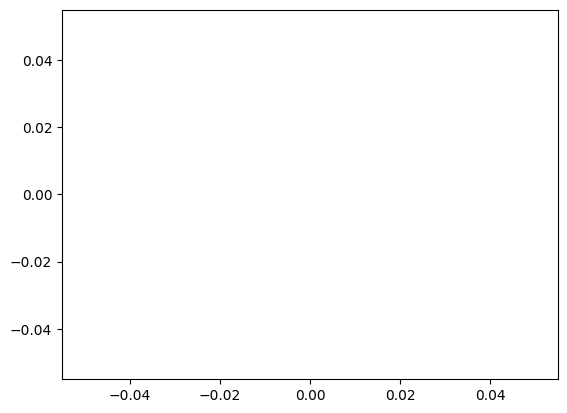

In [ ]:
plt.plot(np.log(test_losses))

In [ ]:
FPS = 24

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter("train.mp4", fourcc, FPS, (500, 500))

for idx, frame in enumerate(train_images):
    fig, axs = plt.subplots(1, 2, dpi=300)
    fig.suptitle(f"Epoch {idx + 1}/{EPOCHS}")
    axs[0].title.set_text("Predicted")
    axs[0].axis("off")
    axs[1].title.set_text("Actual")
    axs[1].axis("off")

    axs[0].imshow(frame)
    axs[1].imshow(full_seq[200, 4])

    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    frame_resized = cv2.resize(frame, (500, 500))
    writer.write(cv2.cvtColor(frame_resized, cv2.COLOR_RGB2BGR))
    plt.close(fig)
writer.release()

/var/folders/jd/lb_vbvw54zd00wp54hlkx4_m0000gn/T/ipykernel_83880/2893470254.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
